# Whats an MCMC and why do we use it?

### The parameter problem
In any model that we build we have a problem where we have a set of unknown 
parameters that we are trying to solve for. In order to figure out what those
parameters are we use data to inform our estimate about the parameter.

## Obligatory fair coin example
Suppose we have a coin and we are trying to figure out what the probability of 
heads is for the coin.  
Since we know that a coin can either be heads or tails we can model this with a 
binomial distribution.  
$Binom(1,p)$  
The parameter then that we are trying to estimate is $p$.  
How do we figure out what $p$ aka the probability of heads is???  

### Inference from data
Lets say we flip this coin 300 times and record its frquency of heads.  
From this information we should be able to make an estimate about what our
paramter $p$ is.

In [1]:
# first lets secretly create a probability and then from flipping a coin we will try and guess it
options(jupyter.plot_mimetypes = 'image/png')
set.seed(123)
super_secret_actual_p <- runif(1)

In [2]:
# these are the observations that we observe without knowing the actual probability
N <- 100 
observed <- rbinom(N, 1, super_secret_actual_p)

In [3]:
# we will say 1 = heads
observed

[1] 1 0 1 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 1 0
 [38] 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0
 [75] 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0

## The Big Bad MLE

![alternate text](https://media.giphy.com/media/bojCyGOjooVy0/giphy.gif)

Now that we have our observed values we can make an estimate about what $p$ is.  
One approach is using the Maximum Likelihood Estimate(MLE) approach.  
MLE says given a likelihood function that takes parameters and 
data and returns a value the maximum value found will be the best guess.  
Formally this is expressed as  

$ln ~ \mathcal{L}(\theta | x_1, x_2, ..., x_n) = \sum_{i=1}^{N} ln ~ \mathcal{f}(\theta|x_i)$  

The likelihood function for the p paramter in the binomial disribution given some data is  

$ln ~ \mathcal{L}(p | x,n) = ln \big(\frac{n!}{x!(n-x)!}p^{x}(1-p)^{n-x} \big)$  

where 
$p$ is a $p$ value we are testing  
$n$ is the number times we flipped a the coin  
$x$ is how many heads we saw in the data  

No one knows why any of that is right but it is I promise  
![](http://i.imgur.com/Uavdtsy.gif)

In [176]:
# calculate the likelihood in R
likelihood <- function(p, obs=observed){
    n <- length(obs)
    x <- sum(obs)
    l <- (factorial(n)/(factorial(x) * factorial(n-x))) * p**x * (1-p)**(n-x)
    log(l)
}

Now that we have a likelihood function we can test different values 
of p to see which one gives us the largest result.

In [177]:
# Whats the liklehood of a fair coin
likelihood(.5)

[1] -13.40173

In [178]:
# what about more heads than tails?
likelihood(.6)

[1] -24.76853

In [179]:
# what about more tails than heads?
likelihood(.4)

[1] -6.117132

It looks like this coin favors tails over heads because the MLE is higher for 
value of lower than .5 rather than .5. What about testing lots of values?

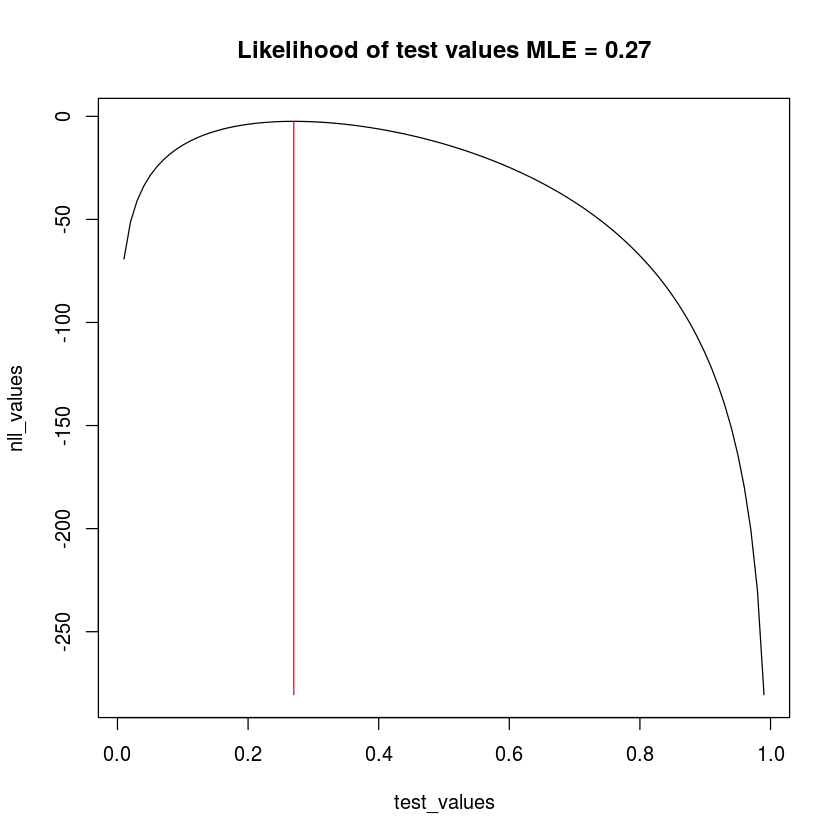

In [180]:
test_values <- seq(from=.01, to=.99, by=.01)
nll_values <- sapply(test_values, likelihood)
MLE <- test_values[which(nll_values == max(nll_values))]
plot(test_values, nll_values, type="l", main=paste0("Likelihood of test values MLE = ", MLE))
lines(c(MLE, MLE), c(min(nll_values), max(nll_values)), col="red")

After testing a bunch of values it looks like MLE says our best guess is about .27  
Actually R has a built in optemizer functions that we can use to calculate this too.  
You give it a likelihood function and a start value and it will return the paramater estimate.  
It even gives the uncertainty if you do some maths. 
![](https://media.giphy.com/media/9lMoyThpKynde/giphy.gif)

In [141]:
fit <- optim(.5, fn=likelihood, obs=observed, lower=0.01, 
             upper=.99, control=list(fnscale=-1), hessian=T, method="L-BFGS-B")

In [147]:
fisher_info<-solve(-fit$hessian)
prop_sigma<-sqrt(fisher_info)
prop_sigma<-diag(prop_sigma)
upper<-fit$par+1.96*prop_sigma
lower<-fit$par-1.96*prop_sigma
interval<-data.frame(value=fit$par, upper=upper, lower=lower)

In [148]:
c(lower=lower, mean=fit$par, upper=upper)

lower      mean     upper 
0.1829855 0.2700008 0.3570161

But actually this is pretty much what GLM is doing under the hood...

In [149]:
glm_fit <- glm(observed ~ 1, family="binomial")

In [160]:
glm_intervals <- confint.default(glm_fit)

In [161]:
1 / (1 + exp(-1 * c(lower=glm_intervals[1,1], mean=glm_fit$coefficients[[1]], upper=glm_intervals[1,2])))

lower      mean     upper 
0.1921507 0.2700000 0.3651341

But why are the intervals (slightly) different?  
The algorithms used for maximization in GLM are a little different.  
Also thats more maths than i know.

## Bayes (the alternative to MLE)

MLE is only one way to solve this problem we could also approach this problem  
form a bayesian approach.  
The bayes approach says you have a prior an idea of what the parameter should be.  
You also use the likelihood (the datur) and this updates your beliefs.  
This will give you a posterior ie your knew beliefs given the data.  
Formally this looks like  
$P(A|B) = \frac{P(B|A)P(A)}{P(B)}$  
where...
$A$ is our hypothesis  
$B$ is our data  
$P(B|A)$ is the likelihood or the probabilty of data when hypothesis is true  
$P(A)$ the prior, or probability of our hypothesis  
$P(B)$ the probability of data given all hypothesis  
$P(A|B)$ posterior, or the probability of our hypothesis given our data  
The biggest fundamental differnece between Bayes and the MLE (a type of "frequentist" approach) 
is  

__From a bayesian standpoint a paramter is a random variable__  
__From a frequentist standpoint a paramter is a fixed, albeit unknown, variable__  
__From my viewpoint the JEDI are evil__

![Image of Yaktocat](http://globalhealth.washington.edu/sites/default/files/styles/faculty/public/faculty/Ng,%20Marie.JPG)

This means that p is not fixed and if its not fixed it has a distribution and if 
it has a distribution we can try and estimate it  
First things first we need a prior $P(A)$

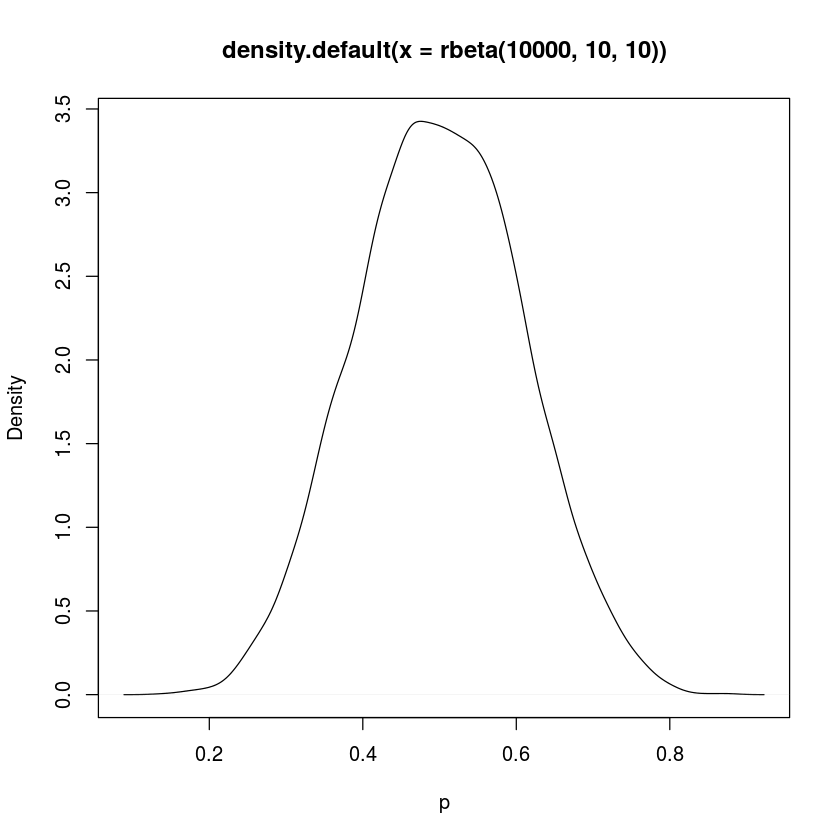

In [167]:
# lets get a prior for p
prior <- function(p){
    dbeta(p,10,10,log=TRUE)
}

# I choose a beta prior because its a probability ditribution from 0-1 check it
plot(density(rbeta(10000, 10, 10)), xlab="p")

With this prior I am saying that before I see any data i mostly believe that the coin 
has a $p$ of .5 but im pretty open to hearing anything from like $.2$ to $.8$  

So we have our prior $p(A)$ we have our likelihood $P(B|A)$  
we actually dont need a $P(B)$ because everything needs too add to one so all we 
need to do now is calculate $P(A|B)$ or posterior.  
But we dont have numbers we have distributions how do we add those?

### MCMCMCMCMCMCMCMCMCMCMCMCMC
![](https://s-media-cache-ak0.pinimg.com/originals/b6/6a/24/b66a2440818fbdeaaec5f16960d8cfa1.jpg)

What is MCMC???

Its basically a way to walk around a space to find an answer.  
Our Space that we want to walk around is the posterioir distribution space.   
By walking around the space we get an idea of what the distribution looks like.  
MCMC dictates the rules by which we walk around the space. 

The rules for the MCMC as proposed in the Metropolis-Hastings algorithm are as follows.
1. Start at a random parameter value
2. Choosing a new parameter value close to the old value based on some probability 
   density that is called the proposal function
3. Jumping to this new point with a probability p(new)/p(old), where p is the target function, 
   and p>1 means jumping as well

In [168]:
# This is our posterior just the sum of our prior an likelihood

posterior <- function(p){
   return (likelihood(p) + prior(p))
}

In [171]:
######## MCMC Metropolis algorithm ################
 
proposalfunction <- function(p){
    return(rnorm(1,mean = p, sd=c(0.05)))
}
 
run_metropolis_MCMC <- function(startvalue, iterations){
    chain <- array(dim = c(iterations+1,1))
    chain[1,] <- startvalue
    for (i in 1:iterations){
        proposal = proposalfunction(chain[i,])
         
        probab = exp(posterior(proposal) - posterior(chain[i,]))
        if (runif(1) < probab){
            chain[i+1,] = proposal
        }else{
            chain[i+1,] = chain[i,]
        }
    }
    return(chain)
}
 
startvalue <- c(.5)
chain <- run_metropolis_MCMC(startvalue, 10000)
 
burnIn <- 5000
acceptance <- 1-mean(duplicated(chain[-(1:burnIn),]))

So now we have our posterior using the MCMC which is a distribution of our paramter value 
of interest $p$  
What does that leave us with for our final estimate?  
Did we come close did we do it?

### DRUM ROLL!!!

![](http://www.cutecatgifs.com/wp-content/uploads/2014/01/metal.gif)

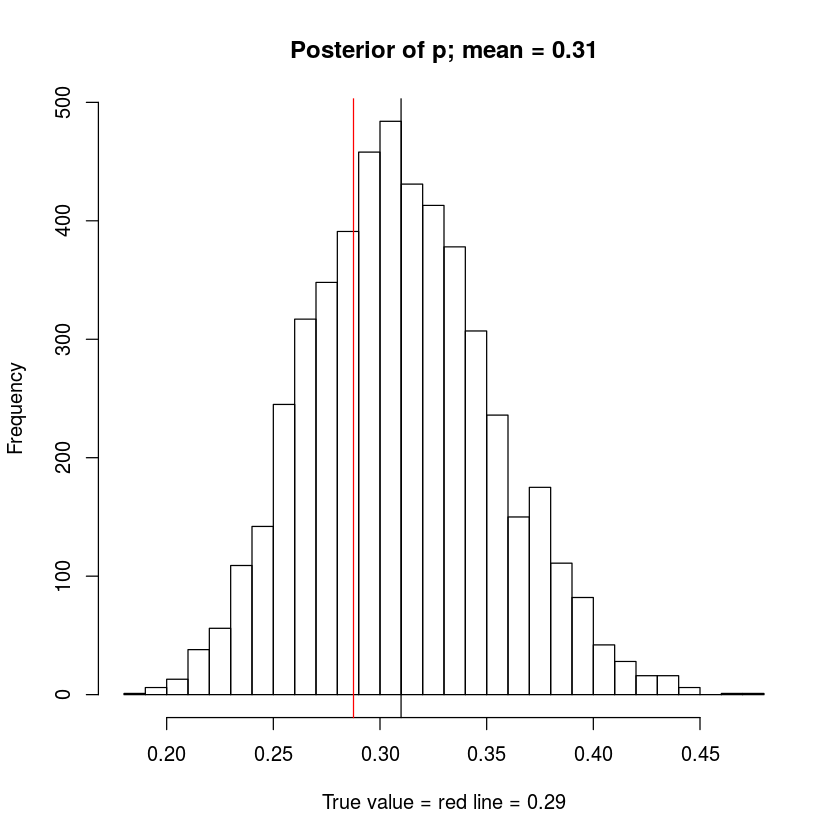

In [175]:
mean_post <- mean(chain[-(1:burnIn),1])
hist(chain[-(1:burnIn),1],nclass=30, , main=paste0("Posterior of p; mean = ", round(mean_post, 2)), 
     xlab=paste0("True value = red line = ", round(super_secret_actual_p, 2)))
abline(v = mean_post)
abline(v = super_secret_actual_p, col="red" )

Sweet we got our paramter back and it looks like a legit estimate.  
Youll notice that the mean estimate from the MCMC process gives us a value 
higher than the MLE.  
This is because our prior shifted the distribution slightly upwards.  

The reason you would want to use a bayesian approach (with MCMC) over a frequentist approach 
(MLE, least sqaures and such) are probably best left for another time but I just wanted to 
walk through some different ways of estimating parameters here.

### Its midnight Im out  
![](http://vignette2.wikia.nocookie.net/glee/images/1/17/Bye_daniel.gif/revision/latest?cb=20110716235001)